In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import gc

# Cleaning

In [3]:
train = pd.read_feather('../input/amexfeather/train_data.ftr')
train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,0


In [4]:
train.shape

(5531451, 191)

In [5]:
train = train.groupby('customer_ID').tail(1)
train = train.set_index('customer_ID', drop=True).sort_index().drop(['S_2'], axis='columns')

In [6]:
train.shape

(458913, 189)

In [7]:
_ = gc.collect()

# Visualisations and understanding

<AxesSubplot:xlabel='target', ylabel='count'>

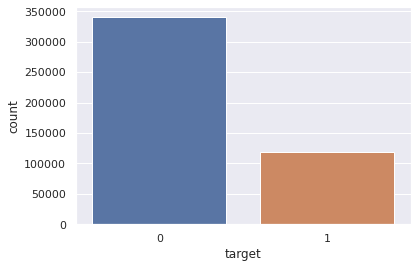

In [8]:
sns.set_theme()
sns.countplot(x=train['target'])

In [9]:
train.isnull().sum().sort_values(ascending=False)

D_87      458268
D_88      458086
D_108     456286
D_111     455235
D_110     455235
           ...  
R_7            0
B_24           0
D_75           0
P_4            0
target         0
Length: 189, dtype: int64

# Pre Processing

In [10]:
cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [11]:
X = train.drop('target',axis=1)
y = train['target']

In [12]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
X[cat_cols] = enc.fit_transform(X[cat_cols])
_ = gc.collect()

In [13]:
X[cat_cols].head()

,B_30,B_38,D_114,D_116,D_117,D_120,D_126,D_63,D_64,D_66,D_68
customer_ID,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.0,1.0,1.0,0.0,4.0,0.0,1.0,2.0,1.0,NaN,5.0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN,5.0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,NaN,5.0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.0,1.0,1.0,0.0,6.0,0.0,1.0,1.0,1.0,NaN,2.0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.0,0.0,1.0,0.0,4.0,0.0,1.0,1.0,1.0,0.0,5.0


# Amex metric

In [14]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [16]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
lgbm = LGBMClassifier(n_estimators=50000,random_state=101,extra_trees=True)

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
def standardize(train_df, test_df):
    scaler = StandardScaler()
    scaler.fit(train_df)
    train_df = scaler.transform(train_df)
    test_df = scaler.transform(test_df)
    return train_df, test_df

def minmax(train_df, test_df):
    scaler = MinMaxScaler()
    scaler.fit(train_df)
    train_df = scaler.transform(train_df)
    test_df = scaler.transform(test_df)
    return train_df, test_df

In [18]:
standardize(X_train,X_test)
minmax(X_train,X_test)

(array([[6.08124460e-01, 1.79687383e-02, 5.97298284e-01, ...,
         9.93230174e-01, 5.56976875e-03, 2.01886125e-02],
        [5.86171132e-01, 2.47192267e-02, 5.13337441e-01, ...,
         5.64026233e-03, 6.60310819e-03, 4.28628767e-04],
        [4.32757131e-01, 1.82617178e-01, 7.40781307e-01, ...,
         2.38568363e-03, 1.98998571e-03, 5.29761453e-04],
        ...,
        [7.72860847e-01, 7.26317176e-03, 7.95363271e-01, ...,
         1.98523634e-03, 5.74009943e-03, 3.65815888e-04],
        [8.96629213e-01, 1.47322418e-03, 5.19589723e-01, ...,
         9.42940039e-03, 2.02263242e-03, 4.63442509e-05],
        [9.04926534e-01, 1.34352447e-03, 5.08853596e-01, ...,
         3.63802587e-03, 3.12268471e-03, 6.59732757e-04]]),
 array([[9.19101124e-01, 1.34276153e-03, 5.05805181e-01, ...,
         5.42114966e-03, 1.33066405e-03, 1.22939422e-03],
        [5.25496975e-01, 7.70938406e-04, 5.15904527e-01, ...,
         5.79893013e-03, 2.34768013e-03, 1.55807544e-03],
        [8.08470182e-01, 

In [19]:
%%time
lgbm.fit(
    X_train, y_train, 
    eval_set=[(X_test,y_test)],
    callbacks=[early_stopping(50), log_evaluation(0)]
)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[328]	valid_0's binary_logloss: 0.22354
CPU times: user 3min 34s, sys: 1.61 s, total: 3min 35s
Wall time: 57.6 s


LGBMClassifier(extra_trees=True, n_estimators=50000, random_state=101)

In [20]:
import pickle
filename = 'LightGBM_1.sav'
pickle.dump(lgbm, open(filename, 'wb'))

In [21]:
y_pred = pd.DataFrame(y_test.copy(deep=True))
y_pred = y_pred.rename(columns={'target':'prediction'})
y_pred

,prediction
customer_ID,
2c4d64e0f7e4453a3029f0b97b82d6f043564f7fe0f0b7f2a100577e716aa967,0
7e48a4b542a5f9fae0516bb5717c1bf791c1fbaf2acd0b43bb434a67d116bd4e,0
25f05a1f5ce5dc8307c92575a086ef8b8dd55ef3a8e4ec57d55372106334e6d8,0
f2def1058c382a207505944cb9cbba6e1e2ceb2166986d03aeae1917c904cbdc,0
a7ed3417ceb016a6ac139626cf011fa0a25dd992d2bbde5f7ba58a843e04376f,0
...,...
78f1ea2491fe19f2be4808063917bdcb25e30bc129fe606e52557cc8017b4ac2,0
f809ac6415b36dc77ec493da776c8e84ff354152c741e80fe82a0d44bdf6ad0d,0
9bf15bce55ae0480d828ec6a573a4d33e0a9cc080065834be4f9ed3e46efa422,0


In [22]:
y_pred['prediction'] = lgbm.predict_proba(X_test)[:,1]
y_pred

,prediction
customer_ID,
2c4d64e0f7e4453a3029f0b97b82d6f043564f7fe0f0b7f2a100577e716aa967,0.000916
7e48a4b542a5f9fae0516bb5717c1bf791c1fbaf2acd0b43bb434a67d116bd4e,0.072989
25f05a1f5ce5dc8307c92575a086ef8b8dd55ef3a8e4ec57d55372106334e6d8,0.641552
f2def1058c382a207505944cb9cbba6e1e2ceb2166986d03aeae1917c904cbdc,0.010488
a7ed3417ceb016a6ac139626cf011fa0a25dd992d2bbde5f7ba58a843e04376f,0.002154
...,...
78f1ea2491fe19f2be4808063917bdcb25e30bc129fe606e52557cc8017b4ac2,0.012642
f809ac6415b36dc77ec493da776c8e84ff354152c741e80fe82a0d44bdf6ad0d,0.011409
9bf15bce55ae0480d828ec6a573a4d33e0a9cc080065834be4f9ed3e46efa422,0.000759


In [23]:
y_test = pd.DataFrame(y_test)

In [24]:
%%time
amex_metric(y_test, y_pred)

CPU times: user 509 ms, sys: 88 µs, total: 509 ms
Wall time: 509 ms


0.7855626422331883

In [25]:
del train, X, y, X_test, X_train, y_train, y_test, y_pred
_ = gc.collect()

In [26]:
%%time
test = pd.read_feather('../input/amexfeather/test_data.ftr')
test.head()

CPU times: user 18.1 s, sys: 17.2 s, total: 35.3 s
Wall time: 41.1 s


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.631348,0.001912,0.010727,0.814453,0.007545,0.168701,0.009972,0.002348,...,NaN,NaN,NaN,NaN,0.004669,NaN,NaN,NaN,0.008278,NaN
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.586914,0.005276,0.011024,0.811035,0.001817,0.241333,0.000166,0.009132,...,NaN,NaN,NaN,0.000142,0.004940,0.009018,NaN,0.003695,0.003754,0.001460
2,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-04-25,0.608887,0.003326,0.016388,1.004883,0.000114,0.267090,0.004196,0.004192,...,NaN,NaN,NaN,0.000074,0.002113,0.004658,NaN,0.003155,0.002155,0.006481
3,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-05-20,0.614746,0.009064,0.021667,0.816406,0.009720,0.188965,0.004124,0.015327,...,NaN,NaN,NaN,0.004742,0.006393,0.002890,NaN,0.006042,0.005207,0.007858
4,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-06-15,0.591797,0.238770,0.015930,0.810547,0.002026,0.180054,0.000731,0.011284,...,NaN,NaN,NaN,0.008133,0.004330,0.008385,NaN,0.001008,0.007420,0.009468


In [27]:
test =  (test.groupby('customer_ID').tail(1).set_index('customer_ID', drop=True).sort_index().drop(['S_2'], axis='columns'))

In [28]:
%%time
test[cat_cols] = enc.transform(test[cat_cols])
_ = gc.collect()

CPU times: user 1.48 s, sys: 57.2 ms, total: 1.53 s
Wall time: 1.53 s


In [31]:
test["prediction"] = lgbm.predict_proba(test)[:,1]
test.head()
test.shape

(924621, 189)

In [32]:
test["prediction"].to_csv("Finalpred1.csv", index=True)